In [8]:
import tensorflow.compat.v1 as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")
# Supress tf version 2
tf.disable_v2_behavior()

In [10]:
zoo = pd.read_csv("./input/zoo2.data.csv")
print("This ZOO dataset is consised of",len(zoo),"rows.")
zoo.head()

This ZOO dataset is consised of 101 rows.


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,habitat
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1,3
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1,3
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4,1
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1,3
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1,3


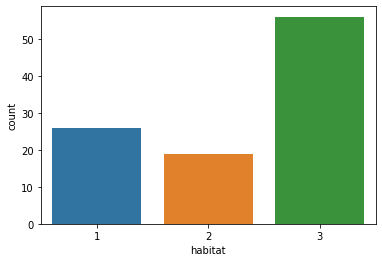

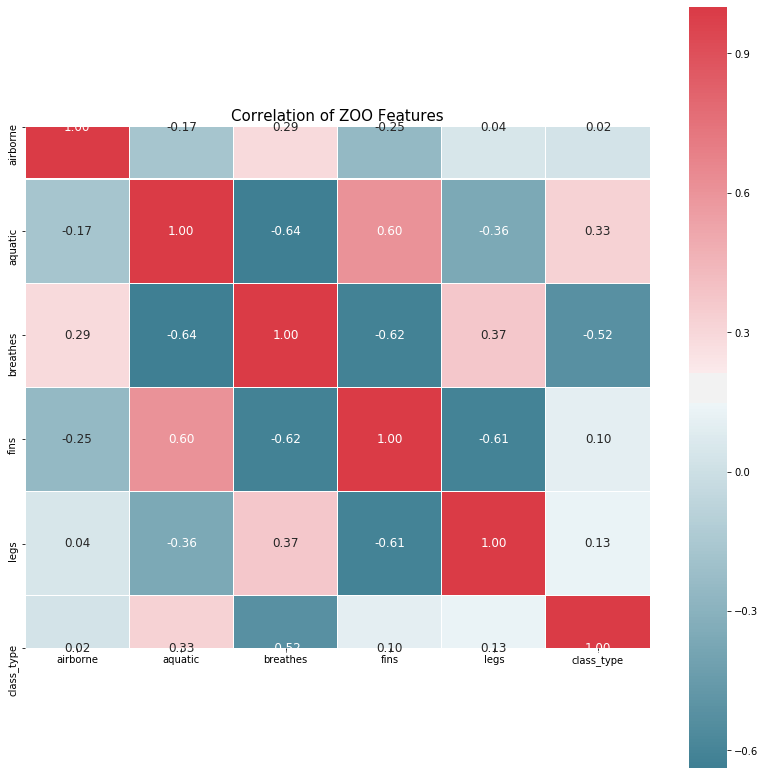

In [11]:
#menghitung jumlah animal berdasarkan class nya
sns.countplot(zoo['habitat'],label="Count")

#plotting dari 6 fitur
corr = zoo.loc[:,('animal_name','airborne','aquatic','breathes','fins','legs','class_type')].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of ZOO Features', y=1.05, size=15)
plt.show()

In [12]:
#kolom prediksi untuk training. Itu ada -1 karena kolom yang habitat nya dihilangkan
x_data = zoo.loc[:,('animal_name','airborne','aquatic','breathes','fins','legs','class_type')]
x_data.head()


,animal_name,airborne,aquatic,breathes,fins,legs,class_type
0,aardvark,0,0,1,0,4,1
1,antelope,0,0,1,0,4,1
2,bass,0,1,0,1,0,4
3,bear,0,0,1,0,4,1
4,boar,0,0,1,0,4,1


#kolom prediksi untuk training. Itu ada -1 karena kolom yang habitat nya dihilangkan
x_data = zoo.loc[:,('animal_name','airborne','aquatic','breathes','fins','legs','class_type')]
x_data.head()
#untuk membandingkan dengan hasil prediksi
y_data = zoo.iloc[:,-1:]
y_data.head()


In [13]:
#untuk membandingkan dengan hasil prediksi
y_data = zoo.iloc[:,-1:]
y_data.head()

,habitat
0,3
1,3
2,1
3,3
4,3


In [16]:

#(101,7) 
print("Feature Data :", x_data.shape)
#(101,1), label outputnya sendiri kan bakalan cuma 1 kolom
print("Label Data :", y_data.shape)

#Data displit jadi 70:30
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=47, stratify=y_data)
print("Training Data has",train_x.shape)
print("Testing Data has",test_x.shape)


train_name = train_x['animal_name' ] #save animal name untuk hasil
test_name = test_x['animal_name'] #save animal buat test

train_x = train_x.iloc[:,1:] #animal_name di drop karena tidak penting 
test_x = test_x.iloc[:,1:]

print("Training Data has",train_x.shape)
print("Testing Data has",test_x.shape)

X = tf.placeholder(tf.float32, [None,6]) #zoo data kan punya 16 fitur
Y = tf.placeholder(tf.int32, [None, 1]) #outputnya cuma 1 kolom, yaitu class animal nya
Y_one_hot = tf.one_hot(Y, 6)  # one hot encoding
Y_one_hot = tf.reshape(Y_one_hot, [-1, 6])

Feature Data : (101, 7)
Label Data : (101, 1)
Training Data has (80, 7)
Testing Data has (21, 7)
Training Data has (80, 6)
Testing Data has (21, 6)
Tensor("Reshape_2:0", shape=(?, 6), dtype=float32)


In [17]:
#W = weight (16,7), 16 karena ada 16 feature, sedangkan 7 karena mau ada 7 hasil berdasarkan class nya
W = tf.Variable(tf.random_normal([6, 6],seed=0), name='weight')
#bias, kenapa 7? karena mau ada 7 layer (tipe)
b = tf.Variable(tf.random_normal([6],seed=0), name='bias')
#Output = Weight * Input + Bias
logits = tf.matmul(X, W) + b
# hypothesis = tf.nn.softmax(logits)
hypothesis = tf.nn.softmax(logits)

cost_i = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y_one_hot)
cost = tf.reduce_mean(cost_i)
# cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis)))


train  = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)
#train = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost) 

#compare original vs prediksi
prediction = tf.argmax(hypothesis, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(16000):
        sess.run(train, feed_dict={X: train_x, Y: train_y})
        if epoch % 100 == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
            print("Epoch: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(epoch, loss, acc))
      
    train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
    test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: test_x, Y: test_y})
    print("Model Prediction =", train_acc)
    print("Test Prediction =", test_acc)

sub = pd.DataFrame()
sub['Name'] = test_name
sub['Predict_Type'] = test_predict
sub['Origin_Type'] = test_y
sub['Correct'] = test_correct
sub

sub[['Name','Predict_Type','Origin_Type','Correct']].to_csv('submission.csv',index=False)
out = sub.to_json(orient='records')
with open('test_result.json', 'w') as f:
    f.write(out)

Epoch:     0	Loss: 2.391	Acc: 22.50%
Epoch:   100	Loss: 1.094	Acc: 60.00%
Epoch:   200	Loss: 0.947	Acc: 62.50%
Epoch:   300	Loss: 0.864	Acc: 62.50%
Epoch:   400	Loss: 0.801	Acc: 62.50%
Epoch:   500	Loss: 0.748	Acc: 62.50%
Epoch:   600	Loss: 0.702	Acc: 65.00%
Epoch:   700	Loss: 0.662	Acc: 70.00%
Epoch:   800	Loss: 0.627	Acc: 73.75%
Epoch:   900	Loss: 0.595	Acc: 73.75%
Epoch:  1000	Loss: 0.567	Acc: 73.75%
Epoch:  1100	Loss: 0.543	Acc: 82.50%
Epoch:  1200	Loss: 0.520	Acc: 85.00%
Epoch:  1300	Loss: 0.501	Acc: 86.25%
Epoch:  1400	Loss: 0.483	Acc: 86.25%
Epoch:  1500	Loss: 0.467	Acc: 86.25%
Epoch:  1600	Loss: 0.452	Acc: 88.75%
Epoch:  1700	Loss: 0.439	Acc: 88.75%
Epoch:  1800	Loss: 0.427	Acc: 88.75%
Epoch:  1900	Loss: 0.416	Acc: 88.75%
Epoch:  2000	Loss: 0.406	Acc: 88.75%
Epoch:  2100	Loss: 0.397	Acc: 88.75%
Epoch:  2200	Loss: 0.388	Acc: 88.75%
Epoch:  2300	Loss: 0.380	Acc: 88.75%
Epoch:  2400	Loss: 0.373	Acc: 88.75%
Epoch:  2500	Loss: 0.366	Acc: 88.75%
Epoch:  2600	Loss: 0.360	Acc: 88.75%
E